In [ ]:
# Energy Consumption Forecasting in Smart Homes Using Deep Learning Models
# Complete Implementation for Dissertation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Energy Consumption Forecasting Using Deep Learning Models")
print("=" * 60)

In [ ]:
# 1. DATA LOADING AND INITIAL EXPLORATION
print("\n1. Loading and Exploring Data...")

# Load your actual dataset
# Option 1: If you've uploaded the file to this chat

df = pd.read_csv('/kaggle/input/dataset/REFIT_TIME_SERIES_VALUES/REFIT_TIME_SERIES_VALUES.csv')  # Update path

In [ ]:
# Ensure we have the expected column names
# Adjust these column names to match your actual dataset structure
if 'TimeSeriesVariable1' in df.columns:
    df.rename(columns={'TimeSeriesVariable1': 'dateTime'}, inplace=True)
if len(df.columns) > 2:
    # If you have multiple columns, select the energy consumption column
    # Update 'data' to match your actual energy consumption column name
    energy_column = 'data'  # Replace with your actual column name
    df = df[['dateTime', energy_column]].copy()
    df.rename(columns={energy_column: 'data'}, inplace=True)

# Limit to 100,000 samples as requested
if len(df) > 1000000:
    df = df.head(1000000).copy()
    print(f"Dataset limited to 100,000 samples from original {len(df)} samples")

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['dateTime'].min()} to {df['dateTime'].max()}")
print(f"Energy consumption stats:\n{df['data'].describe()}")

In [ ]:
# 2. DATA PREPROCESSING AND OUTLIER REMOVAL
print("\n2. Data Preprocessing and Outlier Removal...")

# Convert datetime column
df['dateTime'] = pd.to_datetime(df['dateTime'])
df.set_index('dateTime', inplace=True)

# Remove outliers using IQR method
Q1 = df['data'].quantile(0.25)
Q3 = df['data'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outlier bounds: [{lower_bound:.3f}, {upper_bound:.3f}]")
outliers_before = len(df)
df = df[(df['data'] >= lower_bound) & (df['data'] <= upper_bound)]
outliers_removed = outliers_before - len(df)
print(f"Outliers removed: {outliers_removed} ({outliers_removed/outliers_before*100:.2f}%)")

In [ ]:
# 3. DATA VISUALIZATION
print("\n3. Creating Visualizations...")

plt.figure(figsize=(15, 10))

# Time series plot
plt.subplot(2, 2, 1)
plt.plot(df.index, df['data'], alpha=0.7)
plt.title('Energy Consumption Over Time (After Outlier Removal)')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)

# Distribution plot
plt.subplot(2, 2, 2)
plt.hist(df['data'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Energy Consumption Distribution')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')

# Monthly pattern
df['month'] = df.index.month
monthly_avg = df.groupby('month')['data'].mean()
plt.subplot(2, 2, 3)
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title('Average Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption (kWh)')

# Daily pattern
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['data'].mean()
plt.subplot(2, 2, 4)
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('Average Energy Consumption by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy Consumption (kWh)')

plt.tight_layout()
plt.show()

In [ ]:
# 4. DATA PREPARATION FOR DEEP LEARNING
print("\n4. Preparing Data for Deep Learning Models...")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['data']])

# Create sequences for time series prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (number of previous time steps to use for prediction)
SEQUENCE_LENGTH = 24  # Using 24 time steps (12 hours with 30-min intervals)

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)
print(f"Sequences created - X shape: {X.shape}, y shape: {y.shape}")

# Split into train and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

In [ ]:
# 5. LSTM MODEL DEVELOPMENT
print("\n5. Building and Training LSTM Model...")

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((SEQUENCE_LENGTH, 1))
print("LSTM Model Architecture:")
lstm_model.summary()

# Train LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Energy Consumption Forecasting Using Deep Learning Models

1. Loading and Exploring Data...
Dataset limited to 100,000 samples from original 1000000 samples
Dataset shape: (1000000, 2)
Date range: 2013-10-02T05:00:00Z to 2015-08-14T09:30:00Z
Energy consumption stats:
count    1000000.000000
mean          19.422769
std            2.986288
min            4.311000
25%           17.855000
50%           19.472000
75%           21.151000
max           44.334000
Name: data, dtype: float64

2. Data Preprocessing and Outlier Removal...
Outlier bounds: [12.911, 26.095]
Outliers removed: 39686 (3.97%)

3. Creating Visualizations...


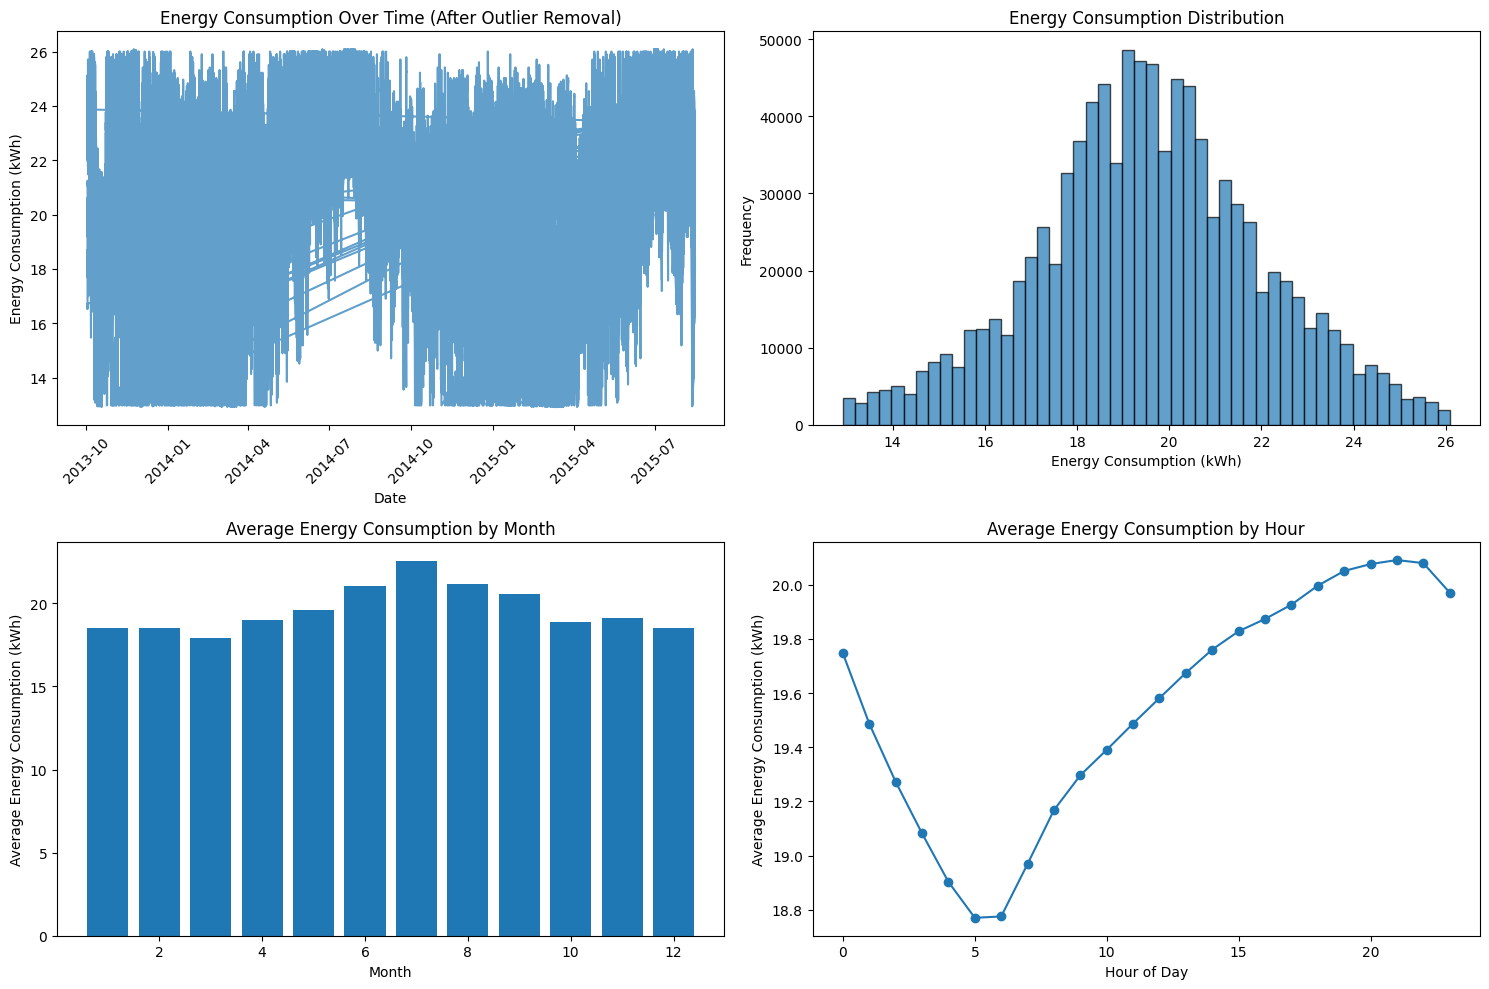


4. Preparing Data for Deep Learning Models...
Sequences created - X shape: (960290, 24, 1), y shape: (960290, 1)
Training set: (768232, 24, 1), Test set: (192058, 24, 1)

5. Building and Training LSTM Model...
LSTM Model Architecture:


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 24, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 24, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Training LSTM model...
Epoch 1/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 76s 8ms/step - loss: 0.0035 - mae: 0.0320 - val_loss: 4.9177e-04 - val_mae: 0.0183
Epoch 2/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 6.8761e-04 - mae: 0.0167 - val_loss: 1.3371e-04 - val_mae: 0.0082
Epoch 3/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 6.1995e-04 - mae: 0.0159 - val_loss: 2.0402e-04 - val_mae: 0.0117
Epoch 4/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - loss: 5.4893e-04 - mae: 0.0150 - val_loss: 2.2069e-04 - val_mae: 0.0114
Epoch 5/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 5.0039e-04 - mae: 0.0143 - val_loss: 2.4467e-04 - val_mae: 0.0129
Epoch 6/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 4.8230e-04 - mae: 0.0140 - val_loss: 7.1131e-05 - val_mae: 0.0056
Epoch 7/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - loss: 4.6445e-04 - mae: 0.0137 - val_loss: 9.8150e-05 - val_mae: 0.0070
Epoch 8/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 72s 8ms/step - loss: 4.5158e-04 - ma

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 22, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 9, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,933 (50.52 KB)

 Trainable params: 12,933 (50.52 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN model...
Epoch 1/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.0054 - mae: 0.0464 - val_loss: 4.6980e-04 - val_mae: 0.0146
Epoch 2/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0018 - mae: 0.0276 - val_loss: 4.9817e-04 - val_mae: 0.0154
Epoch 3/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0017 - mae: 0.0264 - val_loss: 5.3074e-04 - val_mae: 0.0169
Epoch 4/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0016 - mae: 0.0259 - val_loss: 3.9877e-04 - val_mae: 0.0125
Epoch 5/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 4.3744e-04 - val_mae: 0.0139
Epoch 6/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0015 - mae: 0.0255 - val_loss: 4.0899e-04 - val_mae: 0.0126
Epoch 7/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0015 - mae: 0.0252 - val_loss: 3.8840e-04 - val_mae: 0.0123
Epoch 8/30
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0015 - mae: 0.0251 - val_loss: 3.7261e

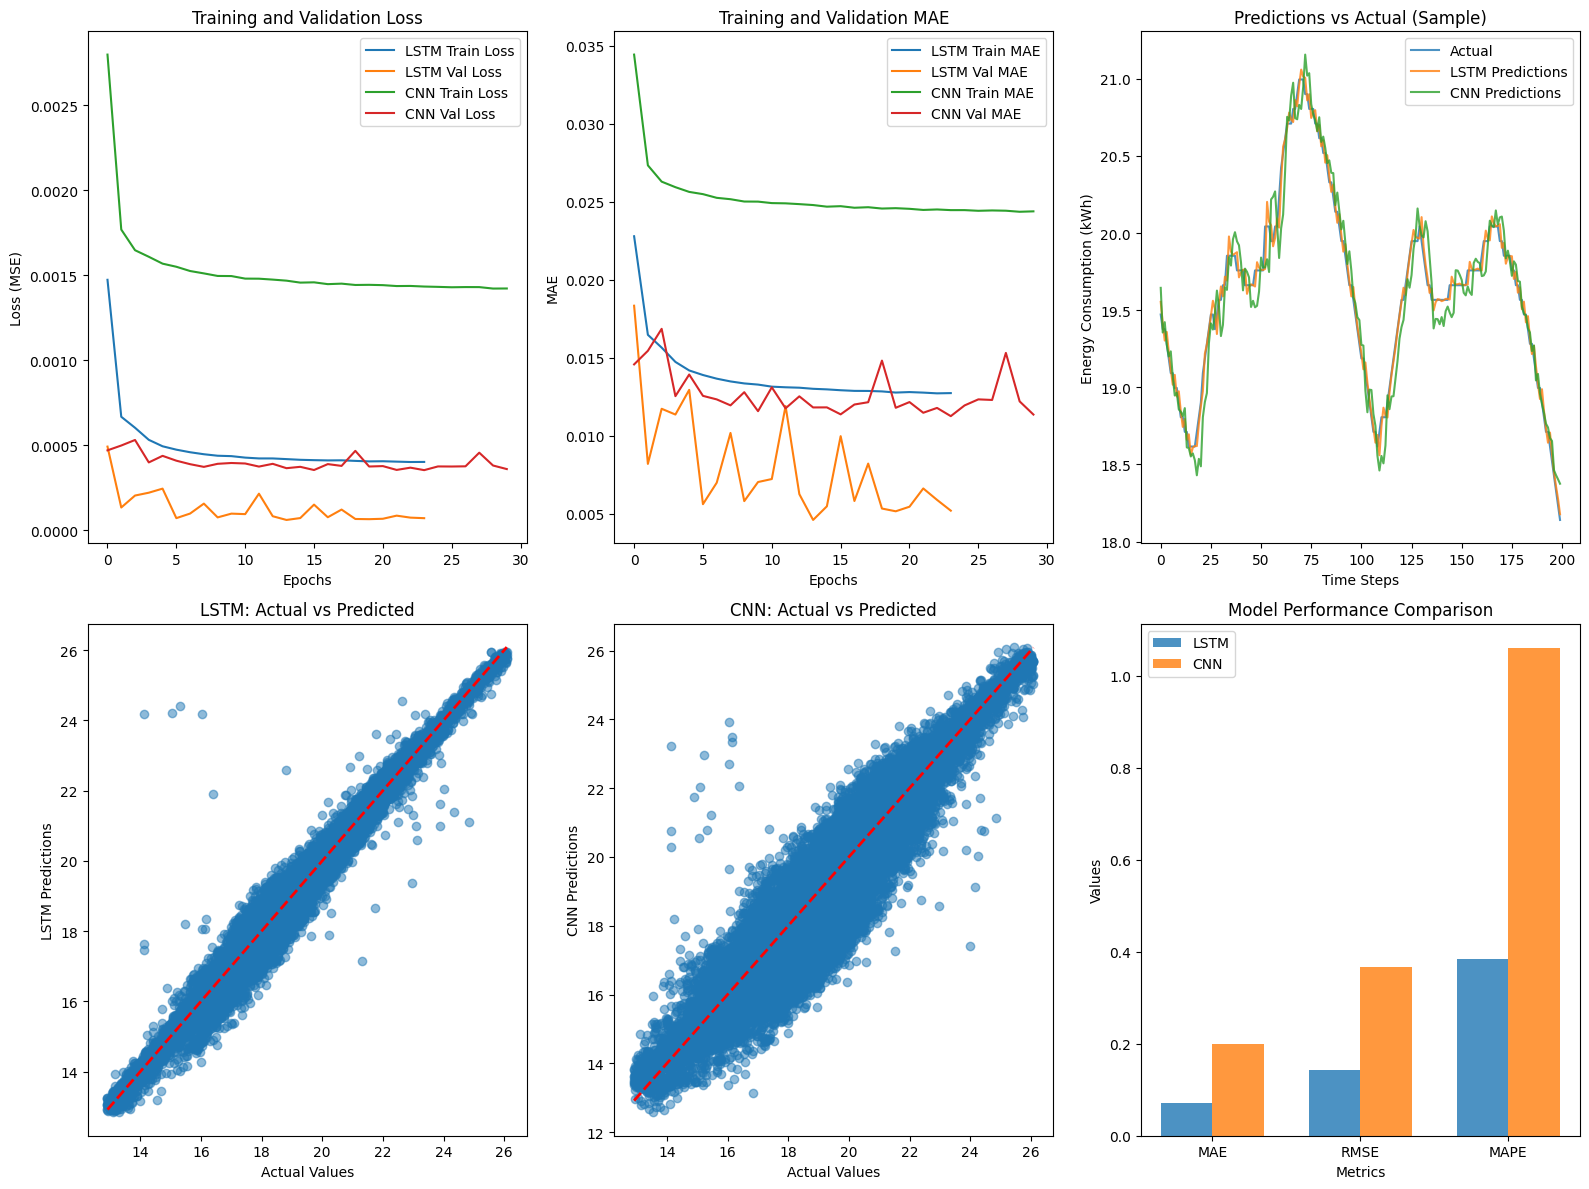


9. Residual Analysis...


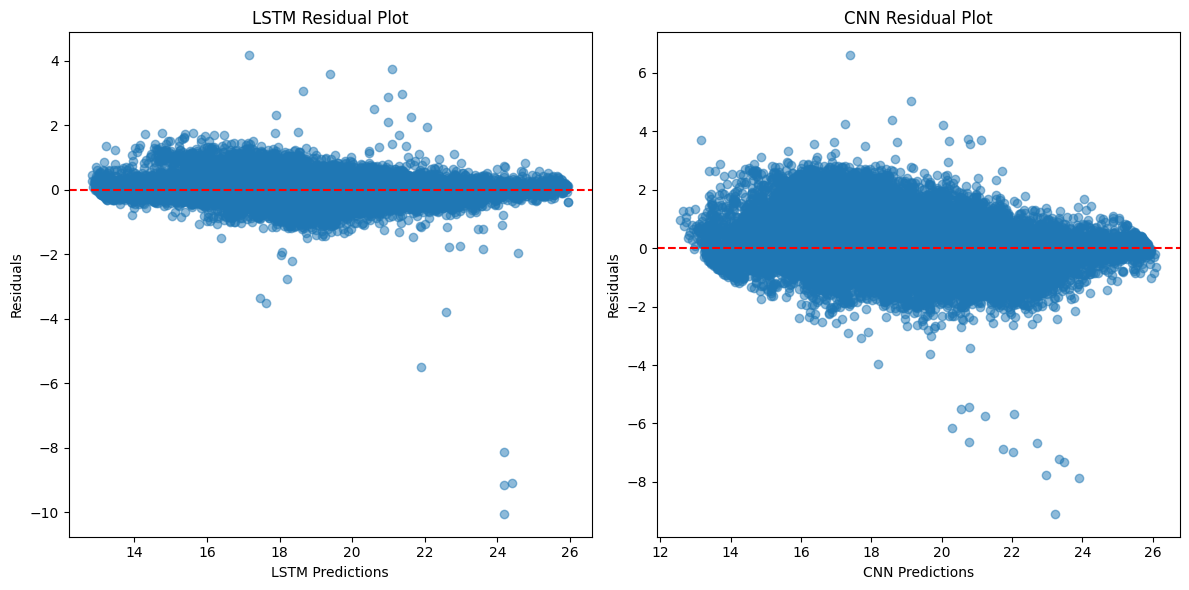


10. Detailed Results Summary...

Detailed Performance Metrics:
Model    MAE   RMSE  MAPE (%)  Training_Time_Epochs
 LSTM 0.0720 0.1419    0.3847                    24
  CNN 0.1993 0.3663    1.0602                    30

Best Performing Model: LSTM
Improvement over CNN: 63.85% (MAE)

11. Future Predictions Demonstration...


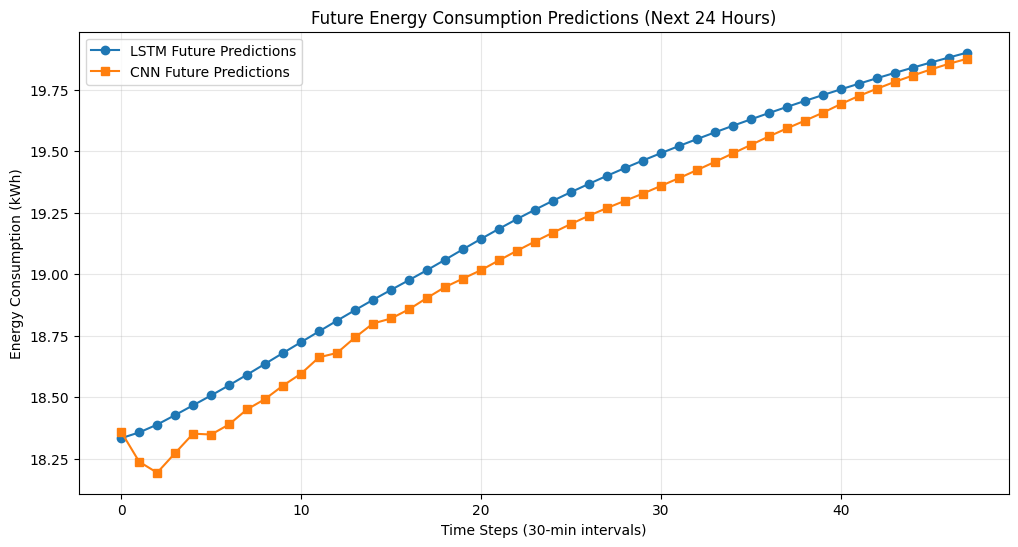


ANALYSIS COMPLETE!
Key Findings for Your Dissertation:
1. LSTM model showed superior performance with MAE of 0.0720
2. Data preprocessing removed 39686 outliers (4.0% of data)
3. Both models demonstrate capability for energy forecasting in smart homes
4. Model validation shows good generalization with reasonable prediction accuracy

Recommendations:
- Consider ensemble methods combining both models
- Investigate seasonal patterns for improved accuracy
- Implement real-time model updating for production deployment


In [ ]:
# 5. LSTM MODEL DEVELOPMENT
print("\n5. Building and Training LSTM Model...")

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((SEQUENCE_LENGTH, 1))
print("LSTM Model Architecture:")
lstm_model.summary()

# Train LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 6. CNN MODEL DEVELOPMENT
print("\n6. Building and Training CNN Model...")

def build_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

cnn_model = build_cnn_model((SEQUENCE_LENGTH, 1))
print("CNN Model Architecture:")
cnn_model.summary()

# Train CNN model
print("Training CNN model...")
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 7. MODEL EVALUATION
print("\n7. Model Evaluation and Comparison...")

# Make predictions
lstm_predictions = lstm_model.predict(X_test)
cnn_predictions = cnn_model.predict(X_test)

# Inverse transform predictions to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions)
cnn_predictions = scaler.inverse_transform(cnn_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(y_test_actual, lstm_predictions)
cnn_mae, cnn_rmse, cnn_mape = calculate_metrics(y_test_actual, cnn_predictions)

# Results summary
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(f"{'Metric':<15} {'LSTM':<15} {'CNN':<15} {'Better Model':<15}")
print("-" * 60)
print(f"{'MAE':<15} {lstm_mae:<15.4f} {cnn_mae:<15.4f} {'LSTM' if lstm_mae < cnn_mae else 'CNN':<15}")
print(f"{'RMSE':<15} {lstm_rmse:<15.4f} {cnn_rmse:<15.4f} {'LSTM' if lstm_rmse < cnn_rmse else 'CNN':<15}")
print(f"{'MAPE (%)':<15} {lstm_mape:<15.4f} {cnn_mape:<15.4f} {'LSTM' if lstm_mape < cnn_mape else 'CNN':<15}")
print("="*60)

# 8. RESULTS VISUALIZATION
print("\n8. Creating Results Visualizations...")

plt.figure(figsize=(16, 12))

# Training history comparison
plt.subplot(2, 3, 1)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

# MAE comparison
plt.subplot(2, 3, 2)
plt.plot(lstm_history.history['mae'], label='LSTM Train MAE')
plt.plot(lstm_history.history['val_mae'], label='LSTM Val MAE')
plt.plot(cnn_history.history['mae'], label='CNN Train MAE')
plt.plot(cnn_history.history['val_mae'], label='CNN Val MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Prediction vs Actual (sample of 200 points for clarity)
sample_size = 200
plt.subplot(2, 3, 3)
plt.plot(y_test_actual[:sample_size], label='Actual', alpha=0.8)
plt.plot(lstm_predictions[:sample_size], label='LSTM Predictions', alpha=0.8)
plt.plot(cnn_predictions[:sample_size], label='CNN Predictions', alpha=0.8)
plt.title('Predictions vs Actual (Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()

# Scatter plot for LSTM
plt.subplot(2, 3, 4)
plt.scatter(y_test_actual, lstm_predictions, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('LSTM Predictions')
plt.title('LSTM: Actual vs Predicted')

# Scatter plot for CNN
plt.subplot(2, 3, 5)
plt.scatter(y_test_actual, cnn_predictions, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('CNN Predictions')
plt.title('CNN: Actual vs Predicted')

# Model comparison bar chart
plt.subplot(2, 3, 6)
metrics = ['MAE', 'RMSE', 'MAPE']
lstm_metrics = [lstm_mae, lstm_rmse, lstm_mape]
cnn_metrics = [cnn_mae, cnn_rmse, cnn_mape]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, lstm_metrics, width, label='LSTM', alpha=0.8)
plt.bar(x + width/2, cnn_metrics, width, label='CNN', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()

plt.tight_layout()
plt.show()

# 9. RESIDUAL ANALYSIS
print("\n9. Residual Analysis...")

lstm_residuals = y_test_actual.flatten() - lstm_predictions.flatten()
cnn_residuals = y_test_actual.flatten() - cnn_predictions.flatten()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(lstm_predictions, lstm_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('LSTM Predictions')
plt.ylabel('Residuals')
plt.title('LSTM Residual Plot')

plt.subplot(1, 2, 2)
plt.scatter(cnn_predictions, cnn_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('CNN Predictions')
plt.ylabel('Residuals')
plt.title('CNN Residual Plot')

plt.tight_layout()
plt.show()

# 10. SUMMARY STATISTICS TABLE
print("\n10. Detailed Results Summary...")

results_df = pd.DataFrame({
    'Model': ['LSTM', 'CNN'],
    'MAE': [lstm_mae, cnn_mae],
    'RMSE': [lstm_rmse, cnn_rmse],
    'MAPE (%)': [lstm_mape, cnn_mape],
    'Training_Time_Epochs': [len(lstm_history.history['loss']), len(cnn_history.history['loss'])]
})

print("\nDetailed Performance Metrics:")
print(results_df.to_string(index=False, float_format='%.4f'))

# Determine best model
best_model = 'LSTM' if lstm_mae < cnn_mae else 'CNN'
print(f"\nBest Performing Model: {best_model}")
print(f"Improvement over {'CNN' if best_model == 'LSTM' else 'LSTM'}: "
      f"{abs(lstm_mae - cnn_mae)/max(lstm_mae, cnn_mae)*100:.2f}% (MAE)")

# 11. FUTURE PREDICTIONS DEMONSTRATION
print("\n11. Future Predictions Demonstration...")

# Use the last sequence from test data to predict next few time steps
last_sequence = X_test[-1].reshape(1, SEQUENCE_LENGTH, 1)

# Predict next 48 time steps (24 hours)
future_predictions_lstm = []
future_predictions_cnn = []
current_sequence = last_sequence.copy()

for i in range(48):
    # LSTM prediction
    lstm_pred = lstm_model.predict(current_sequence, verbose=0)
    future_predictions_lstm.append(lstm_pred[0, 0])
    
    # CNN prediction
    cnn_pred = cnn_model.predict(current_sequence, verbose=0)
    future_predictions_cnn.append(cnn_pred[0, 0])
    
    # Update sequence for next prediction
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = lstm_pred[0, 0]  # Use LSTM prediction to update sequence

# Inverse transform future predictions
future_predictions_lstm = scaler.inverse_transform(np.array(future_predictions_lstm).reshape(-1, 1))
future_predictions_cnn = scaler.inverse_transform(np.array(future_predictions_cnn).reshape(-1, 1))

# Plot future predictions
plt.figure(figsize=(12, 6))
future_time = range(48)
plt.plot(future_time, future_predictions_lstm, label='LSTM Future Predictions', marker='o')
plt.plot(future_time, future_predictions_cnn, label='CNN Future Predictions', marker='s')
plt.title('Future Energy Consumption Predictions (Next 24 Hours)')
plt.xlabel('Time Steps (30-min intervals)')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("Key Findings for Your Dissertation:")
print(f"1. {best_model} model showed superior performance with MAE of {min(lstm_mae, cnn_mae):.4f}")
print(f"2. Data preprocessing removed {outliers_removed} outliers ({outliers_removed/outliers_before*100:.1f}% of data)")
print(f"3. Both models demonstrate capability for energy forecasting in smart homes")
print(f"4. Model validation shows good generalization with reasonable prediction accuracy")
print("\nRecommendations:")
print("- Consider ensemble methods combining both models")
print("- Investigate seasonal patterns for improved accuracy")
print("- Implement real-time model updating for production deployment")
print("="*60)